In [1]:
%%capture
import numpy as np
import pandas as pd
!pip install openpyxl
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/material_science/Spetral_clustering')
%run rbf.ipynb
os.chdir(actual_path)

In [3]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
max_calculated = max_calculated.set_index('prettyformula',drop=True)
whole_data = max_elemental.merge(max_calculated,how='inner',
                                 left_index=True,right_index=True)
whole_data = whole_data.drop(['PU_label','year'],axis=1)
M_elements = pd.get_dummies(whole_data['M'],prefix='M',dtype=float)
A_elements = pd.get_dummies(whole_data['A'],prefix='A',dtype=float)
X_elements = pd.get_dummies(whole_data['X'],prefix='X',dtype=float)
whole_data = whole_data.drop(['M','A','X'],axis=1)
x_group = pd.get_dummies(whole_data['X_X_group'],prefix='x_g',dtype=float)
a_group = pd.get_dummies(whole_data['A_A_group'],prefix='a_g',dtype=float)
m_group = pd.get_dummies(whole_data['M_M_group'],prefix='m_g',dtype=float)
whole_data = whole_data.drop(['X_X_group','A_A_group','M_M_group'],axis=1)
whole_data = pd.concat([whole_data,M_elements,A_elements,X_elements,x_group,
                       a_group,m_group],axis=1)

test_tree = DecisionTreeClassifier().fit(X=whole_data.drop(['class'],axis=1),
                                                              y=whole_data['class'])

imp_feat = test_tree.feature_importances_
names_feat = test_tree.feature_names_in_

imp_feat = imp_feat.reshape(-1,1)
names_feat = names_feat.reshape(-1,1)
test_df = pd.DataFrame(np.hstack((names_feat,imp_feat)))
test_df.columns = ['names_feat','imp_feat']
test_df = test_df.set_index('names_feat',drop=True)
test_df = test_df[test_df['imp_feat'] > 0]

diff_z = list(test_df.index)


number_of_atoms = np.zeros(n_samples)
compteur = 0
for element in whole_data.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1

columns_name = whole_data.drop(['class'],axis=1).columns.copy()
normalized = whole_data.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(-1,1)

data_norm = pd.DataFrame(normalized)
data_norm.columns = columns_name
data_norm['compound_name'] = whole_data.index
data_norm = data_norm.set_index('compound_name',drop=True)

data_norm = data_norm.filter(items=list(diff_z),axis=1)
data_norm['class'] = whole_data['class'].copy()

retained_features = list(test_df.index)

for feat in diff_z:
    if len(feat) > 6:
        retained_features.remove(feat)

list_dummies = []

for i in retained_features:
    if 'M_' in i:
        list_dummies.append(i)
    elif 'A_' in i:
        list_dummies.append(i)
    elif 'X_' in i:
        list_dummies.append(i)
    elif 'x_g' in i:
        list_dummies.append(i)
    elif 'a_g' in i:
        list_dummies.append(i)
    elif 'm_g' in i:
        list_dummies.append(i)

for col in list_dummies:
    for row in data_norm.index:
        if data_norm.loc[row,col] != 0:
            data_norm.loc[row,col] = 1

In [4]:
data_for_cluster = max_elemental.copy()
tree_for_cluster = DecisionTreeClassifier().fit(X=data_for_cluster.drop(['class'],axis=1),
                                                y=data_for_cluster['class'])
imp_feat_cluster = tree_for_cluster.feature_importances_
name_cluster = tree_for_cluster.feature_names_in_

imp_feat_cluster = imp_feat_cluster.reshape(-1,1)
name_cluster = name_cluster.reshape(-1,1)
df_for_cluster = pd.DataFrame(np.hstack((name_cluster,imp_feat_cluster)))
df_for_cluster.columns = ['names_feat','imp_feat']
df_for_cluster = df_for_cluster.set_index('names_feat',drop=True)
df_for_cluster = df_for_cluster[df_for_cluster['imp_feat'] > 0]
diff_z_cluster = list(df_for_cluster.index)



number_of_atoms_cluster = np.zeros(n_samples)
compteur_cluster = 0
for element in data_for_cluster.index:
    inter_cluster = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter_cluster.append(cara)
    if len(inter_cluster) == 1:
        number_of_atoms_cluster[compteur_cluster] = int(inter_cluster[0]) + 2
    elif len(inter_cluster) == 2:
        number_of_atoms_cluster[compteur_cluster] = int(inter_cluster[0]) + int(inter_cluster[1]) + 1
    elif len(inter_cluster) == 3:
        number_of_atoms_cluster[compteur_cluster] = int(inter_cluster[0]) + int(inter_cluster[1]) + int(inter_cluster[2])
    compteur_cluster += 1

columns_name_cluster = data_for_cluster.drop(['class'],axis=1).columns.copy()
normalized_cluster = data_for_cluster.drop(['class'],axis=1).to_numpy()/number_of_atoms_cluster.reshape(-1,1)

data_norm_cl = pd.DataFrame(normalized_cluster)
data_norm_cl.columns = columns_name_cluster
data_norm_cl['compound_name'] = data_for_cluster.index
data_norm_cl = data_norm_cl.set_index('compound_name',drop=True)

data_norm_cl = data_norm_cl.filter(items=list(diff_z_cluster),axis=1)
data_norm_cl['class'] = data_for_cluster['class'].copy()

retained_features_cl = list(df_for_cluster.index)

for feat in diff_z_cluster:
    if len(feat) > 6:
        retained_features_cl.remove(feat)

list_dummies_cl = []

for i in retained_features_cl:
    if 'M_' in i:
        list_dummies_cl.append(i)
    elif 'A_' in i:
        list_dummies_cl.append(i)
    elif 'X_' in i:
        list_dummies_cl.append(i)
    elif 'x_g' in i:
        list_dummies_cl.append(i)
    elif 'a_g' in i:
        list_dummies_cl.append(i)
    elif 'm_g' in i:
        list_dummies_cl.append(i)

for col in list_dummies_cl:
    for row in data_norm_cl.index:
        if data_norm_cl.loc[row,col] != 0:
            data_norm_cl.loc[row,col] = 1

In [5]:
data_norm_cl

,M_M_atomic_mass,M_M_density,M_M_atomic_radius,M_M_average_ionic_radius,M_M_electronegativity,M_M_second_ionization_energy,M_M_group,A_A_atomic_number,A_A_atomic_mass,A_A_average_cationic_radius,A_A_second_ionization_energy,X_X_atomic_number,X_X_atomic_radius_calculated,X_X_average_ionic_radius,X_X_electron_affinity,class
compound_name,,,,,,,,,,,,,,,,
Sc2AlC,11.238978,1.123898,0.40000,0.221250,0.340,3.199943,0.75,3.250,6.745385,0.168750,4.707137,1.500,0.1675,0.07500,0.315528,0.0
Sc2SiC,11.238978,1.123898,0.40000,0.221250,0.340,3.199943,0.75,3.500,7.021375,0.135000,4.086462,1.500,0.1675,0.07500,0.315528,0.0
Sc2PC,11.238978,1.123898,0.40000,0.221250,0.340,3.199943,0.75,3.750,7.743441,0.137500,4.942373,1.500,0.1675,0.07500,0.315528,0.0
Sc2SC,11.238978,1.123898,0.40000,0.221250,0.340,3.199943,0.75,4.000,8.016250,0.117500,5.834470,1.500,0.1675,0.07500,0.315528,0.0
Sc2MnC,11.238978,1.123898,0.40000,0.221250,0.340,3.199943,0.75,6.250,13.734511,0.162083,3.909997,1.500,0.1675,0.07500,0.315528,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W4AuN3,22.980000,2.298000,0.16875,0.095833,0.295,2.046250,0.75,9.875,24.620821,0.133750,2.525375,0.875,0.0700,0.07875,-0.008750,0.0
W4HgN3,22.980000,2.298000,0.16875,0.095833,0.295,2.046250,0.75,10.000,25.073750,0.155625,2.344610,0.875,0.0700,0.07875,-0.008750,0.0
W4TlN3,22.980000,2.298000,0.16875,0.095833,0.295,2.046250,0.75,10.125,25.547912,0.166563,2.553538,0.875,0.0700,0.07875,-0.008750,0.0


In [6]:
n_cluster=10
clusterized_data = KMeans(n_clusters=n_cluster).fit(data_norm_cl.to_numpy()[::-1])
data_norm_cl['cluster'] = clusterized_data.labels_
data_norm_cl = data_norm_cl.filter(items=['cluster'],axis=1)
data_norm = data_norm.merge(right=data_norm_cl, how='left',left_index=True,right_index=True)

In [7]:
data_norm['label'] = np.zeros(n_samples)
for i in data_norm.index:
    if data_norm.loc[i,'class'] == 1:
        data_norm.loc[i,'label'] = 1
    else:
        data_norm.loc[i,'label'] = -1

positive_samples = data_norm[data_norm['label'] == 1]
unlabelled_samples = data_norm[data_norm['label'] == -1]

list_of_ratio = np.zeros(n_cluster)
for i in range(n_cluster):
    list_of_ratio[i] = data_norm[data_norm['cluster'] == i]['class'].sum()/data_norm[data_norm['cluster'] == i].shape[0]
#same code as before but here we use the class because it is 0 or 1
positive_cluster = np.argmax(list_of_ratio)
    
#we cannot exactly compute the ratios because the classes are so unbalanced that in any cases the number of positive
#instances will be very small compared to the ones of unlabelled instances

list_of_dist = np.zeros(n_cluster)
for i in range(n_cluster):
    list_of_dist[i] = np.linalg.norm(clusterized_data.cluster_centers_[positive_cluster,:] - clusterized_data.cluster_centers_[i,:])

negative_cluster = np.argmax(list_of_dist)

In [8]:
df_unlab_pop = data_norm[data_norm['label'] == -1]
list_of_pop = pd.DataFrame(df_unlab_pop.groupby('cluster')['label'].count())
list_of_pop.columns = ['pop']
list_of_pop['dist'] = list_of_dist #distance to the positive cluster
list_of_pop = list_of_pop.sort_values('dist',ascending=False)
list_of_pop['cumsum'] = np.cumsum(list_of_pop['pop'])

In [9]:
reliable_positives = data_norm[data_norm['label'] == 1]
n_positives = reliable_positives.shape[0]
last_step = np.where(np.array(list_of_pop['cumsum'])>n_positives*10)[0][0]
index_ordered_distance = list(list_of_pop.index)
if last_step == 0:
    reliable_negatives = data_norm[data_norm['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
else:
    compteur=0
    reliable_negatives = data_norm[data_norm['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
    while compteur<last_step:
        interm_negatives = data_norm[data_norm['cluster'] == index_ordered_distance[compteur+1]]
        interm_negatives = interm_negatives[interm_negatives['label'] == -1]
        reliable_negatives = pd.concat([reliable_negatives,interm_negatives])
        compteur += 1
    del interm_negatives, compteur

In [10]:
reliable_negatives = reliable_negatives.head(n=n_positives*10)

In [11]:
#Step of initialization of labels
train_clf_data = pd.concat([reliable_positives,reliable_negatives])
index_of_labels = list(train_clf_data.index)
unlabelled_data = data_norm.drop(labels=index_of_labels,axis=0)
index_of_unlabelled = list(unlabelled_data.index)
first_step_clf = SVC().fit(X=train_clf_data.drop(['class','label','cluster'],axis=1).to_numpy(),
                          y=train_clf_data['label'].to_numpy())
unlabelled_data['relab'] = first_step_clf.predict(unlabelled_data.drop(['class','label','cluster'],axis=1).to_numpy())

In [12]:
gamma = 1
good_ratio = 1/10
max_iter = 10
compteur = 0
train_clf_data['relab'] = train_clf_data['label'].copy()
updated_data = pd.concat([train_clf_data,unlabelled_data])
up_data_np = updated_data.to_numpy()[:,:-4].copy()
positive_index_list = list(data_norm[data_norm['class'] == 1].index)

In [13]:
right_side = np.vstack((np.zeros(1).reshape(1,1),np.ones(n_samples).reshape(n_samples,1))) #its for the 
#computation of the matrix to det the coeffs so put it here to avoid doing it each time
while compteur<max_iter:
    compteur += 1
    labels = updated_data['relab'].to_numpy().reshape(1,-1)
    first_row = np.hstack((np.array(0).reshape(1,1),(-1)*labels))
    
    #computation of omega and the coefficients
    omega = np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        for k in range(i,n_samples):
            omega[i,k] = rbf(x=up_data_np[i,:],y=up_data_np[k,:],l_squared=10)*labels[0,i]*labels[0,k]
            omega[k,i] = omega[i,k]
        omega[i,i] = 1

    bot_right = omega + gamma*np.eye(n_samples)
    bot = np.hstack((updated_data['relab'].to_numpy().reshape(n_samples,1), bot_right))
    whole_mat = np.vstack((first_row, bot))
    
    del bot_right, bot, first_row

    coeffs = np.linalg.solve(a=whole_mat,b=right_side)


    alpha = coeffs[1:]

    #once we have the coefficients, we can compute the labels of the unlabelled instances

    updated_data['to_det_b'] = np.zeros(n_samples)
    count_for_loop = 0
    for i in updated_data.index:
        updated_data.loc[i,'to_det_b'] = np.sum(alpha*labels*rbf(x=up_data_np,y=up_data_np[count_for_loop,:],l_squared=10))
        count_for_loop += 1
    to_det_b_arr = np.array(updated_data['to_det_b']).copy()
    b = np.sort(to_det_b_arr)[int((1-good_ratio)*n_samples)]
    
    updated_data['check_array'] = np.zeros(n_samples)
    count_diff = 0
    
    for i in updated_data.index:
        if i in positive_index_list:
            updated_data.loc[i,'check_array'] = 1
        else:
            updated_data.loc[i,'check_array'] = np.sign(updated_data.loc[i,'to_det_b']-b)
            if updated_data.loc[i,'check_array'] != updated_data.loc[i,'relab']:
                count_diff += 1
    
    if count_diff == 0:
        break
    else:
        updated_data['relab'] = updated_data['check_array'].copy()

In [14]:
test_results = np.zeros(positive_samples.shape[0])
test_set = positive_samples.to_numpy()[:,:-3]

In [15]:
for i in range(positive_samples.shape[0]):
    test_results[i] = np.sign(np.sum(alpha*labels*rbf(x=up_data_np,y=test_set[i,:],l_squared=10))-b)

In [16]:
true_positives = 0
for i in range(positive_samples.shape[0]):
    if test_results[i] == 1:
        true_positives += 1

In [17]:
recall = true_positives/positive_samples.shape[0]

In [18]:
#'V4AlC3' 'Nb4AlC3' are missclassified
#'Ta4AlC3' is the 'frontier', it's the one that defines 'r'

In [19]:
number_of_predicted_positives = 0
for i in updated_data.drop(labels=list(positive_samples.index),axis=0).index:
    if updated_data.loc[i,'check_array'] == 1:
        number_of_predicted_positives += 1

In [20]:
weird_metric = (recall**2)/(number_of_predicted_positives/updated_data.drop(labels=list(positive_samples.index),axis=0).shape[0])

In [21]:
ordered_pred_df = updated_data[updated_data['check_array'] == 1].sort_values(by='to_det_b',ascending=False)

In [22]:
ordered_pred_df[ordered_pred_df['class'] == 1]

,A_A_second_ionization_energy,dMA,dAA,rMX,rMA,e_M,dEc,density,dEf,dH,M_Ti,M_V,A_Al,A_Zn,class,cluster,label,relab,to_det_b,check_array
compound_name,,,,,,,,,,,,,,,,,,,,
Ta2AlC,4.707137,0.557933,1.745500,0.546693,0.714878,0.236375,1884.426031,2.870454,-131.844990,-2.501170,0.0,0.0,1.0,0.0,1.0,3,1.0,1.0,421.044962,1.0
Ti2AlC,4.707137,0.572010,1.717437,0.527455,0.723328,0.329452,1585.313992,0.999209,-175.367182,-4.433290,1.0,0.0,1.0,0.0,1.0,8,1.0,1.0,420.672980,1.0
Nb2AlC,4.707137,0.559453,1.742738,0.548930,0.719043,0.241175,1702.981879,1.578442,-126.534736,-4.223056,0.0,0.0,1.0,0.0,1.0,7,1.0,1.0,420.671466,1.0
Ti2SC,5.834470,0.424882,1.408950,0.540368,0.627973,0.383445,1705.123542,1.158582,-312.925067,-14.156324,1.0,0.0,0.0,0.0,1.0,8,1.0,1.0,420.665820,1.0
Ti2ZnC,4.491098,0.571775,1.720762,0.527335,0.722298,0.335172,1396.775752,1.289542,-135.340198,6.033368,1.0,0.0,0.0,1.0,1.0,3,1.0,1.0,420.665820,1.0
Ti2AlN,4.707137,0.560543,1.703050,0.521497,0.708165,0.311277,1534.357291,1.070180,-292.858890,-13.392717,1.0,0.0,1.0,0.0,1.0,8,1.0,1.0,420.665819,1.0
Ti3SiC2,2.724308,0.339795,1.477625,0.357025,0.450538,0.248850,1168.330449,0.746292,-137.080337,-1.351975,1.0,0.0,0.0,0.0,1.0,6,1.0,1.0,419.269149,1.0
Ti3ZnC2,2.994065,0.380173,1.551983,0.356583,0.481942,0.243088,1046.059042,0.843894,-110.487900,-1.186989,1.0,0.0,0.0,1.0,1.0,1,1.0,1.0,417.378076,1.0
V2AlC,4.707137,0.541435,1.641212,0.504640,0.685475,0.237250,1507.684761,1.212639,-128.911353,-15.625497,0.0,1.0,1.0,0.0,1.0,3,1.0,1.0,415.909309,1.0


In [23]:
ordered_pred_df = ordered_pred_df.head(100)

In [24]:
ordered_pred_df.to_csv('it_ls_svm_all_features.csv')

In [25]:
ordered_pred_df

,A_A_second_ionization_energy,dMA,dAA,rMX,rMA,e_M,dEc,density,dEf,dH,M_Ti,M_V,A_Al,A_Zn,class,cluster,label,relab,to_det_b,check_array
compound_name,,,,,,,,,,,,,,,,,,,,
Hf2RuN,4.190000,0.518857,1.714100,0.568605,0.691485,0.392118,1856.241366,3.290785,-257.908081,61.815527,0.0,0.0,0.0,0.0,0.0,0,-1.0,1.0,686.339945,1.0
Zr2IrN,4.250000,0.539545,1.746212,0.571415,0.711590,0.402050,1855.314175,2.581628,-258.423365,59.066401,0.0,0.0,0.0,0.0,0.0,1,-1.0,1.0,686.339945,1.0
Nb2BiC,4.175750,0.587753,1.713162,0.559105,0.765365,0.292115,1570.014372,2.466826,-50.500972,36.998108,0.0,0.0,0.0,0.0,0.0,7,-1.0,1.0,584.057977,1.0
Nb2AgC,5.371100,0.603653,1.807238,0.544550,0.755615,0.295360,1565.855050,2.044501,-50.503796,36.995284,0.0,0.0,0.0,0.0,0.0,1,-1.0,1.0,584.052365,1.0
Nb2ReN,4.150000,0.553490,1.739550,0.544382,0.708990,0.308293,1783.639401,2.822158,-108.589796,55.566973,0.0,0.0,0.0,0.0,0.0,1,-1.0,1.0,561.083279,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W2GeC,3.983652,0.497565,1.553238,0.537072,0.676865,0.249875,1719.780766,3.452715,42.141513,57.472206,0.0,0.0,0.0,0.0,0.0,1,-1.0,1.0,420.690247,1.0
W2MnC,3.909997,0.538515,1.683488,0.530090,0.692130,0.191625,1723.110831,3.409572,48.647314,69.373202,0.0,0.0,0.0,0.0,0.0,1,-1.0,1.0,420.690247,1.0
Ta2AgN,5.371100,0.583873,1.750425,0.538820,0.739158,0.301887,1615.868146,3.358555,-92.831402,78.992582,0.0,0.0,0.0,0.0,0.0,1,-1.0,1.0,420.688833,1.0


In [26]:
df_to_plot = max_calculated.filter(items=list(ordered_pred_df.index),axis=0)
df_to_plot = df_to_plot.filter(items=['dEf','dH'],axis=1)

df_no_pos = max_calculated.drop(labels=list(ordered_pred_df.index),axis=0)
df_no_pos = df_no_pos.filter(items=['dEf','dH'],axis=1)

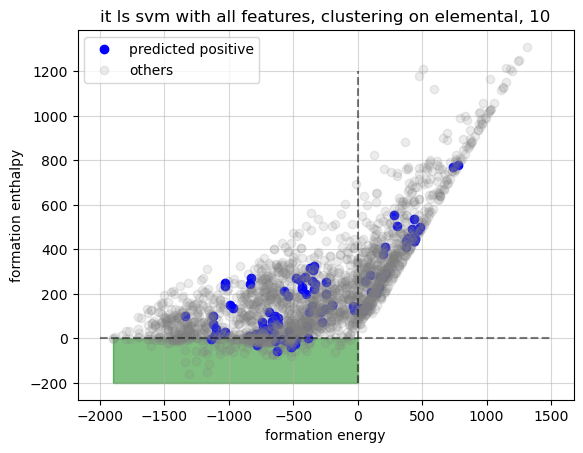

In [27]:
fig, ax = plt.subplots()

ax.plot(df_to_plot['dEf'].to_numpy(),df_to_plot['dH'].to_numpy(),'bo',
         label='predicted positive')
ax.plot(df_no_pos['dEf'].to_numpy(),df_no_pos['dH'].to_numpy(),'o',color='gray',alpha=0.15,
         label='others')
ax.plot(np.linspace(-2000,1500,2,endpoint=True),np.zeros(2),'--k',alpha=0.5)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'--k',alpha=0.5)
ax.fill_between(np.linspace(np.min(df_no_pos['dEf'].to_numpy()),0,2,endpoint=True),y1=-200,y2=0,color='green',alpha=0.5)
ax.grid(alpha=0.5)
ax.set_xlabel(xlabel='formation energy')
ax.set_ylabel(ylabel='formation enthalpy')
ax.set_title('it ls svm with all features, clustering on elemental, 10')
plt.legend()
plt.savefig('it_ls_svm_pred_l_10_r_10_cl_elem_10.png')